# **Presentation of experiment results**
I trained two models for regression problem of predicting value of footbal player based on various features such as general potential, position played, age. There is a lot of non-numerical data and some of them are at the first sight completely unimportant for the prediction task, so that I simply removed them. The deleted features include full name of a player, url adress to his photo and url adress to the photo of his country flag.

In order to achieve better results I scaled the data which are very diverse. The first model is a standard neural network based on linear layers together with ReLU activation functions. The second model is XGBoost which achieves 10 times better results in terms of RMSE. As for the training time, XGBoost gives the result almost immediately, but for the neural network it takes a while backprop and train the weights.

Necessary imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
df_ = pd.read_csv('Fifa 23 Players Data.csv')
df_.head()

,Known As,Full Name,Overall,Potential,Value(in Euro),Positions Played,Best Position,Nationality,Image Link,Age,...,LM Rating,CM Rating,RM Rating,LWB Rating,CDM Rating,RWB Rating,LB Rating,CB Rating,RB Rating,GK Rating
0,L. Messi,Lionel Messi,91,91,54000000,RW,CAM,Argentina,https://cdn.sofifa.net/players/158/023/23_60.png,35,...,91,88,91,67,66,67,62,53,62,22
1,K. Benzema,Karim Benzema,91,91,64000000,"CF,ST",CF,France,https://cdn.sofifa.net/players/165/153/23_60.png,34,...,89,84,89,67,67,67,63,58,63,21
2,R. Lewandowski,Robert Lewandowski,91,91,84000000,ST,ST,Poland,https://cdn.sofifa.net/players/188/545/23_60.png,33,...,86,83,86,67,69,67,64,63,64,22
3,K. De Bruyne,Kevin De Bruyne,91,91,107500000,"CM,CAM",CM,Belgium,https://cdn.sofifa.net/players/192/985/23_60.png,31,...,91,91,91,82,82,82,78,72,78,24
4,K. Mbappé,Kylian Mbappé,91,95,190500000,"ST,LW",ST,France,https://cdn.sofifa.net/players/231/747/23_60.png,23,...,92,84,92,70,66,70,66,57,66,21


# **Data preprocessing**
I preprocess data in the following way:

*   print out all the data of the string type
*   remove those of them which seem irrelevant at first glance
*   change columns containing strings into numerical values
*   normalize the data with sklearn MinMaxScaler





Printing string columns

In [ ]:
for key in df_.keys():
  if type(df_[key][0]) == str:
    print(type(df_[key][0]))
    print(key)
    print(df_[key][0])

<class 'str'>
Known As
L. Messi
<class 'str'>
Full Name
Lionel Messi
<class 'str'>
Positions Played
RW
<class 'str'>
Best Position
CAM
<class 'str'>
Nationality
Argentina
<class 'str'>
Image Link
https://cdn.sofifa.net/players/158/023/23_60.png
<class 'str'>
Club Name
Paris Saint-Germain
<class 'str'>
Club Position
RW
<class 'str'>
Contract Until
2023
<class 'str'>
Club Jersey Number
30
<class 'str'>
On Loan
-
<class 'str'>
Preferred Foot
Left
<class 'str'>
National Team Name
Argentina
<class 'str'>
National Team Image Link
https://cdn.sofifa.net/flags/ar.png
<class 'str'>
National Team Position
RW
<class 'str'>
National Team Jersey Number
10
<class 'str'>
Attacking Work Rate
Low
<class 'str'>
Defensive Work Rate
Low


Dropping non important columns

In [ ]:
non_important_columns = ["Full Name", "Known As", "Image Link", "National Team Image Link"]
#for column_name in non_important_columns:
df = df_.drop(non_important_columns, axis=1, inplace=False)
len(df.keys())

85

Changing text into numerical data

In [ ]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]

        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x+=1

            df[column] = list(map(convert_to_int, df[column]))

    return df
df = handle_non_numerical_data(df)
train_set, test_set = train_test_split(df, test_size=0.2)
feature_names = [feature for feature in df.keys() if feature != "Value(in Euro)"]
x_train, y_train = torch.tensor(train_set[feature_names].values), torch.tensor(train_set["Value(in Euro)"].values)
x_test, y_test = torch.tensor(test_set[feature_names].values), torch.tensor(test_set["Value(in Euro)"].values)

def normalize(data):
  scaler = MinMaxScaler()
  scaler.fit(data)
  return scaler.transform(data)

x_train= normalize(x_train)
y_train = normalize(y_train.unsqueeze(1))
x_test = normalize(x_test)
y_test = normalize(y_test.unsqueeze(1))

Definition of neural network to be trained

In [ ]:
class Net(nn.Module):
  def __init__(self, in_features, out_features):
    super(Net, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.hid1 = nn.Linear(in_features, 64)
    self.hid2 = nn.Linear(64, 16)
    self.oupt = nn.Linear(16, 1)

    nn.init.xavier_uniform_(self.hid1.weight)
    nn.init.zeros_(self.hid1.bias)
    nn.init.xavier_uniform_(self.hid2.weight)
    nn.init.zeros_(self.hid2.bias)
    nn.init.xavier_uniform_(self.oupt.weight)
    nn.init.zeros_(self.oupt.bias)

  def forward(self, x):
    z = F.relu(self.hid1(x))
    z = F.relu(self.hid2(z))
    z = self.oupt(z)  
    return z

Preparing the dataset for pytorch setup

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.costs = y
        self.features = x

    def __len__(self):
        return len(self.costs)

    def __getitem__(self, idx):
        feature = self.features[idx]
        cost = self.costs[idx]
        return feature, cost
train_loader = torch.utils.data.DataLoader(CustomDataset(x_train, y_train), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(CustomDataset(x_test, y_test), batch_size=32, shuffle=True)

Training of the neural network

In [ ]:
def train_model(num_epochs=100):
    device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(x_train.shape[1], 1).to(device)
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    losses_test = []

    for epoch in range(num_epochs):

        loss_test = []
        loss_ = 0
        for features, cost in train_loader:
            model.zero_grad()
            preds = model(features.float().to(device))            
            loss = torch.sqrt(loss_function(preds,cost.float().to(device)))
            loss_ += loss.item()
            loss.backward()
            
            optimizer.step()
        with torch.no_grad():
          loss = 0
          for features, cost in test_loader:
              features = features.to(torch.float32)
              preds = model(features.float().to(device))
              loss += torch.sqrt(loss_function(preds,cost.float().to(device)))
              loss_test.append(loss)
          losses_test.append(torch.tensor(loss_test).mean())
        if epoch%(num_epochs//10) == 0:
          print(f'Test loss in the {epoch}th epoch: {torch.tensor(losses_test).mean()}')
    
    plt.plot(list(range(num_epochs)), losses_test, 'g', label='test loss')
    plt.title('Training and test loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return losses_test

Test loss in the 0th epoch: 3.6502485275268555
Test loss in the 10th epoch: 1.6197651624679565
Test loss in the 20th epoch: 1.320192575454712
Test loss in the 30th epoch: 1.194486379623413
Test loss in the 40th epoch: 1.125713586807251
Test loss in the 50th epoch: 1.0816707611083984
Test loss in the 60th epoch: 1.0341722965240479
Test loss in the 70th epoch: 0.9772336483001709
Test loss in the 80th epoch: 0.9431598782539368
Test loss in the 90th epoch: 0.9033498167991638


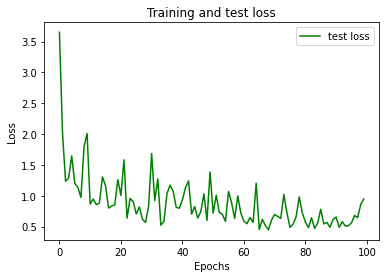

In [ ]:
losses_test = train_model(num_epochs=100)



XGBoost training - at first, I reorganize the data



In [ ]:
X = df[feature_names]
y = df["Value(in Euro)"]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
X_train= normalize(X_train)
y_train = normalize(y_train.values.reshape(-1,1))
X_test = normalize(X_test)
y_test = normalize(y_test.values.reshape(-1,1))

XGBoost training

In [ ]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

[12:31:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Comparison between XGBoost and neural network by their root mean square error

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f'RMSE XGB: {rmse}, RMSE NN: {losses_test[-1]}, ratio: {rmse/losses_test[-1]}')

RMSE XGB: 0.1653453940109935, RMSE NN: 0.9462847113609314, ratio: 0.17473112046718597
